Shape: X=(569, 30), y=(569,)
Classes: {0: 'malignant', 1: 'benign'}


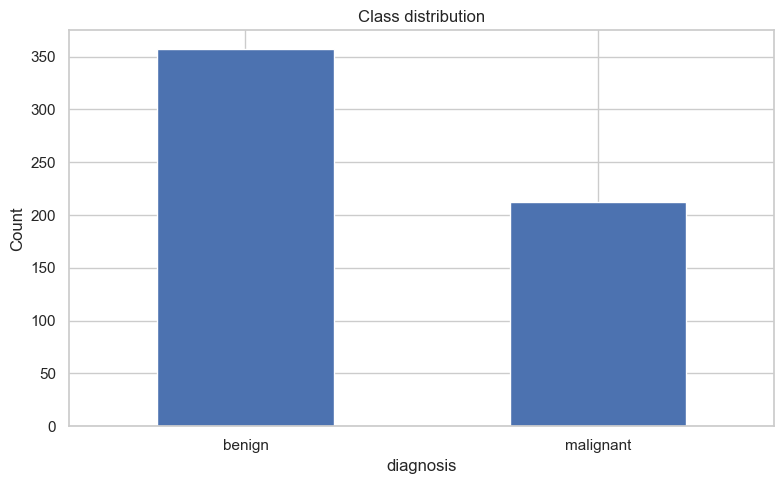


Top correlated feature pairs (absolute):
mean radius      mean perimeter         0.997855
worst radius     worst perimeter        0.993708
mean radius      mean area              0.987357
mean perimeter   mean area              0.986507
worst radius     worst area             0.984015
worst perimeter  worst area             0.977578
radius error     perimeter error        0.972794
mean perimeter   worst perimeter        0.970387
mean radius      worst radius           0.969539
mean perimeter   worst radius           0.969476
mean radius      worst perimeter        0.965137
mean area        worst radius           0.962746
                 worst area             0.959213
                 worst perimeter        0.959120
radius error     area error             0.951830
mean perimeter   worst area             0.941550
mean radius      worst area             0.941082
perimeter error  area error             0.937655
mean concavity   mean concave points    0.921391
mean texture     worst text

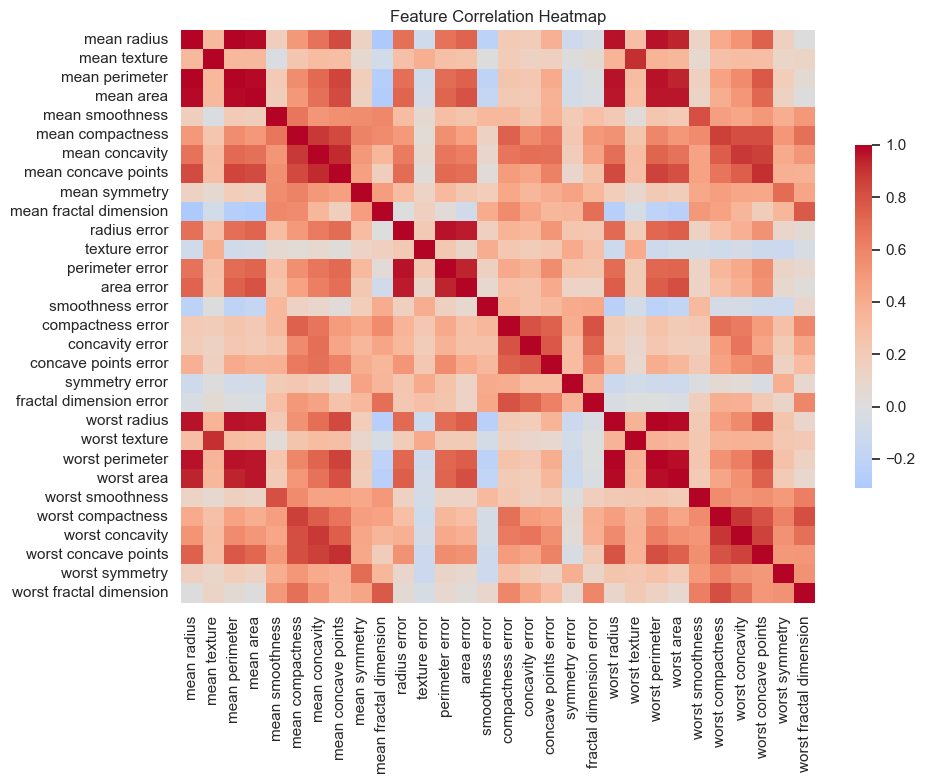

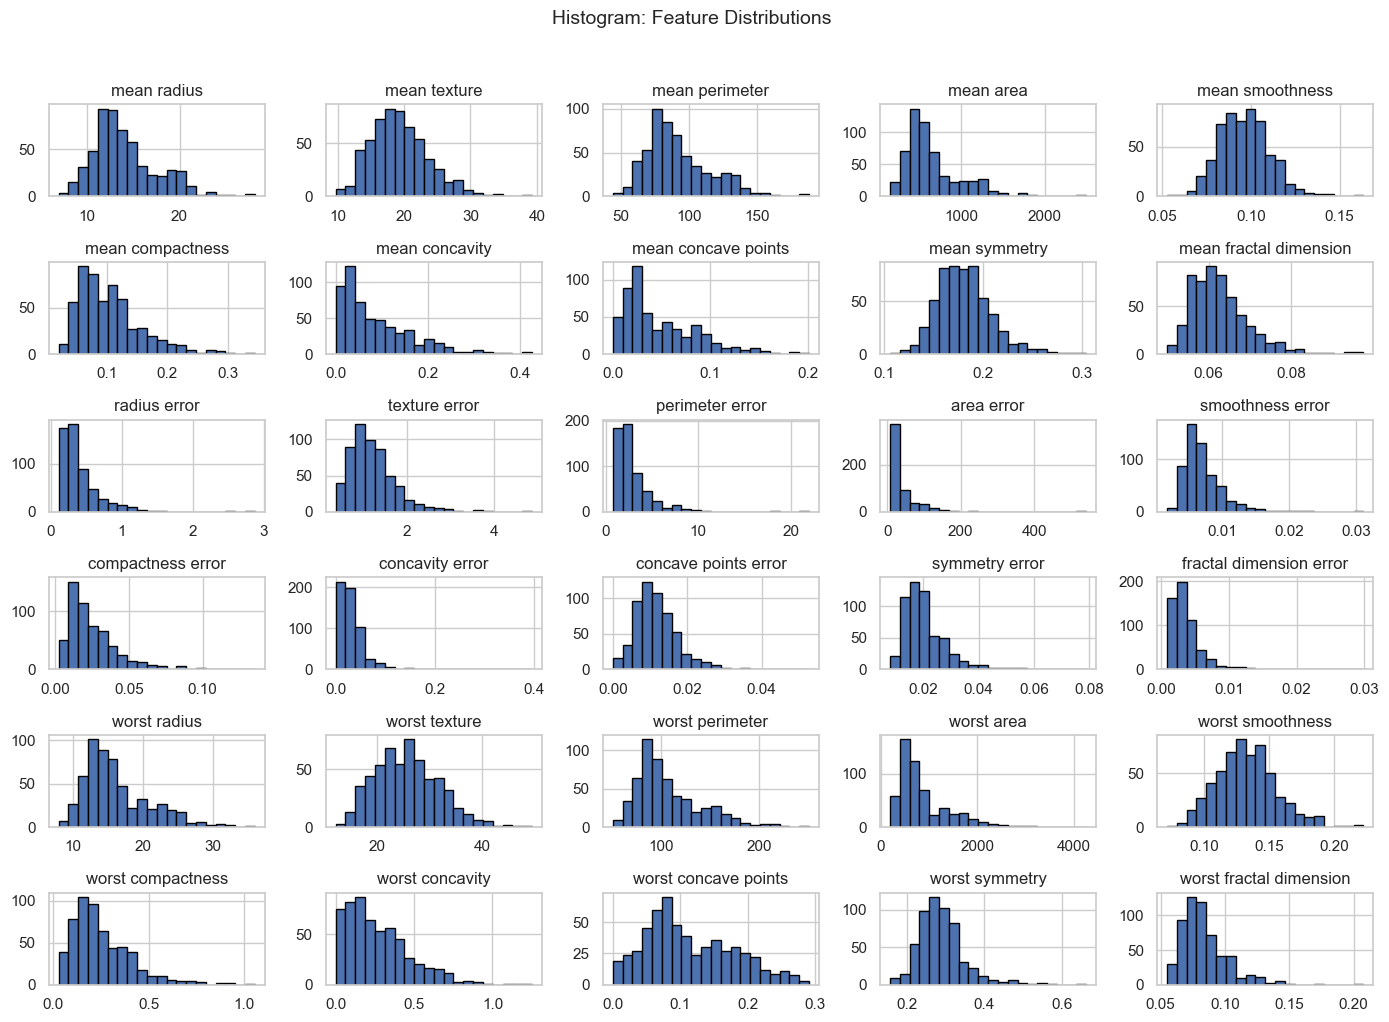

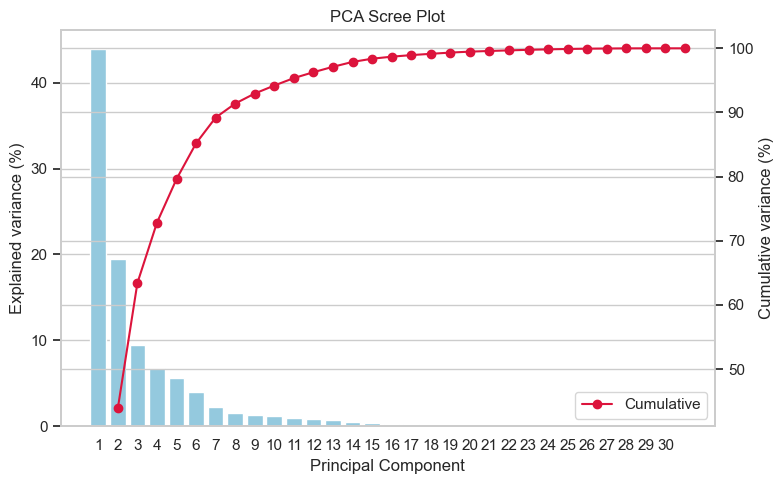

Components for ≥95% variance: 10 / 30


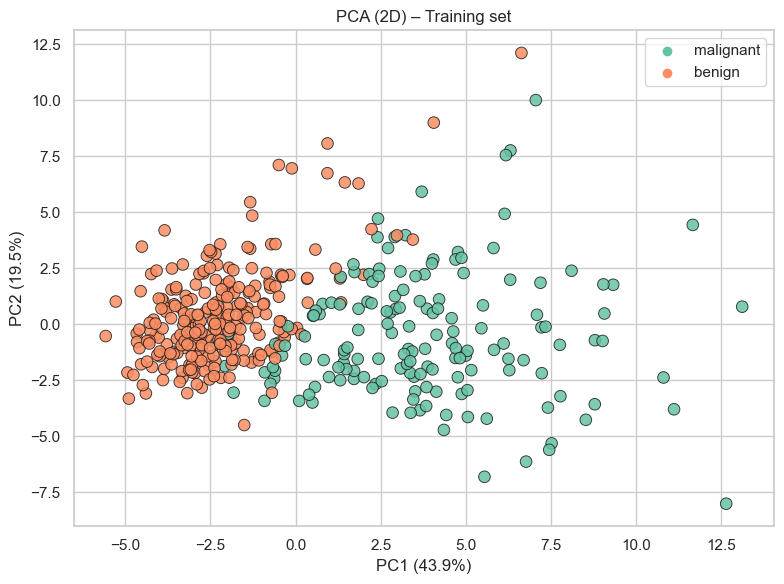

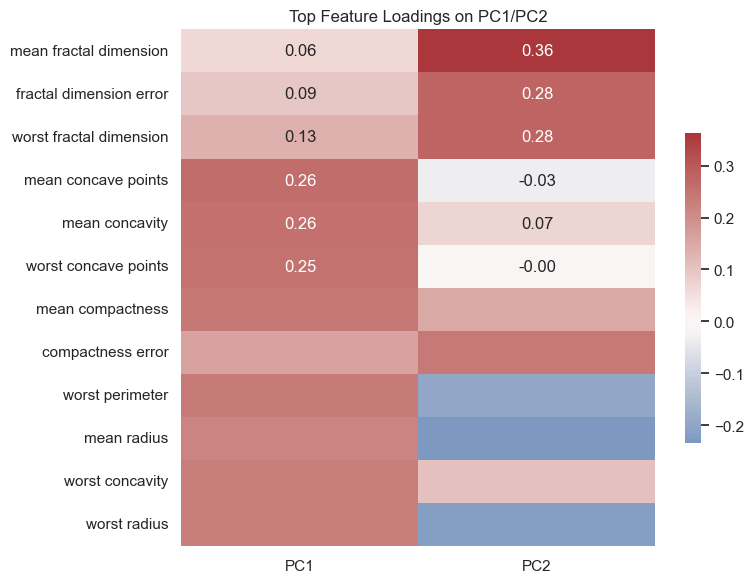


=== Test Set Performance ===
                  model  accuracy  precision  recall      f1
0       LogReg (no PCA)    0.9860     0.9889  0.9889  0.9889
1      SVM-RBF (no PCA)    0.9790     0.9888  0.9778  0.9832
2   LogReg (PCA 10 PCs)    0.9790     0.9888  0.9778  0.9832
3  SVM-RBF (PCA 10 PCs)    0.9720     0.9778  0.9778  0.9778
4   SVM-RBF (PCA 2 PCs)    0.9510     0.9462  0.9778  0.9617
5    LogReg (PCA 2 PCs)    0.9441     0.9556  0.9556  0.9556

Best model: LogReg (no PCA)

Classification Report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



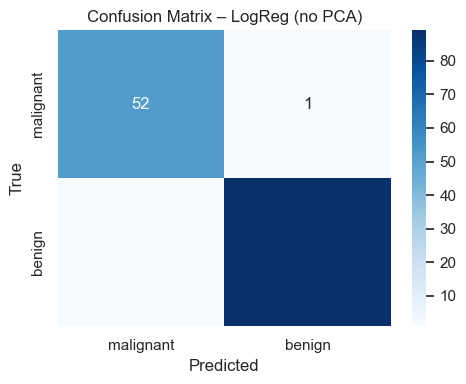


=== 5-fold CV Accuracy (Train Only) ===
LogReg (no PCA): 0.9789 ± 0.0088
LogReg (PCA 10 PCs): 0.9789 ± 0.0171


In [2]:
# ============================================================
# Project 3: Breast Cancer Feature Reduction with PCA
# Dataset: Breast Cancer Wisconsin (Diagnostic) - scikit-learn
# Author: <your name>
# ============================================================

# ---- Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Aesthetic defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

# ============================================================
# 1) Load dataset
# ============================================================
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="diagnosis")  # 0 = malignant, 1 = benign
target_names = list(data.target_names)  # ['malignant','benign']

print(f"Shape: X={X.shape}, y={y.shape}")
print("Classes:", dict(zip([0,1], target_names)))

# ============================================================
# 2) Quick EDA
# ============================================================

# Class balance
class_counts = y.value_counts().rename(index={0:"malignant",1:"benign"})
ax = class_counts.plot(kind="bar", rot=0)
ax.set_title("Class distribution")
ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

# Correlation heatmap (top features only to keep readable)
corr = X.corr()
# Show top-20 absolute correlations to illustrate redundancy
abs_corr = corr.abs()
upper = abs_corr.where(np.triu(np.ones(abs_corr.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .head(20)
)
print("\nTop correlated feature pairs (absolute):")
print(top_pairs)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={"shrink": .6})
plt.title("Feature Correlation Heatmap")
plt.tight_layout(); plt.show()

# Optional: feature distributions (comment out if you want it faster)
_ = X.hist(bins=20, figsize=(14,10), edgecolor="black")
plt.suptitle("Histogram: Feature Distributions", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

# ============================================================
# 3) Train-test split & scaling
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# ============================================================
# 4) PCA fit + variance analysis
# ============================================================
# Fit PCA on scaled training data
pca_full = PCA(random_state=42)
pca_full.fit(X_train_s)

explained = pca_full.explained_variance_ratio_ * 100
cum_explained = np.cumsum(explained)

# Scree plot (variance explained)
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=np.arange(1, len(explained)+1), y=explained, color="skyblue", ax=ax)
ax2 = ax.twinx()
ax2.plot(np.arange(1, len(explained)+1), cum_explained, marker="o", color="crimson", label="Cumulative")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained variance (%)")
ax2.set_ylabel("Cumulative variance (%)")
ax.set_title("PCA Scree Plot")
ax2.legend(loc="lower right")
plt.tight_layout(); plt.show()

# Choose components to keep (e.g., 95% variance)
n95 = np.argmax(cum_explained >= 95) + 1
print(f"Components for ≥95% variance: {n95} / {X.shape[1]}")

# Also try a compact choice like 2 or 3 for visualization
n2, n3 = 2, 3

# ============================================================
# 5) Visualize PCA 2D scatter colored by diagnosis
# ============================================================
pca2 = PCA(n_components=2, random_state=42)
X_train_p2 = pca2.fit_transform(X_train_s)
X_test_p2  = pca2.transform(X_test_s)

df_p2 = pd.DataFrame(X_train_p2, columns=["PC1","PC2"])
df_p2["diagnosis"] = y_train.map({0:"malignant", 1:"benign"}).values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_p2, x="PC1", y="PC2", hue="diagnosis",
    palette="Set2", alpha=0.85, edgecolor="k", s=70
)
expl = pca2.explained_variance_ratio_ * 100
plt.xlabel(f"PC1 ({expl[0]:.1f}%)")
plt.ylabel(f"PC2 ({expl[1]:.1f}%)")
plt.title("PCA (2D) – Training set")
plt.legend(title="")
plt.tight_layout(); plt.show()

# ============================================================
# 6) PCA loadings: which features drive PC1/PC2?
# ============================================================
loadings_2 = pd.DataFrame(
    pca2.components_.T,
    index=X.columns,
    columns=["PC1","PC2"]
)
# Sort by absolute contribution to PC1/PC2 (top 12 shown)
top_loadings = (
    loadings_2.abs()
    .assign(maxabs=lambda d: d.max(axis=1))
    .sort_values("maxabs", ascending=False)
    .drop(columns="maxabs")
    .head(12)
)
plt.figure(figsize=(8,6))
sns.heatmap(
    loadings_2.loc[top_loadings.index], annot=True, fmt=".2f",
    cmap="vlag", center=0, cbar_kws={"shrink": .6}
)
plt.title("Top Feature Loadings on PC1/PC2")
plt.tight_layout(); plt.show()

# ============================================================
# 7) Baseline models (no PCA) vs PCA models
# ============================================================
def eval_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    return {
        "model": name,
        "accuracy": accuracy_score(y_te, pred),
        "precision": precision_score(y_te, pred),
        "recall": recall_score(y_te, pred),
        "f1": f1_score(y_te, pred),
        "report": classification_report(y_te, pred, target_names=target_names, zero_division=0),
        "cm": confusion_matrix(y_te, pred)
    }

# Models
logit = LogisticRegression(max_iter=500, random_state=42)
svmrbf = SVC(kernel="rbf", probability=False, random_state=42)

# --- Baseline (scaled features)
res_baseline_logit = eval_model(logit, X_train_s, y_train, X_test_s, y_test, "LogReg (no PCA)")
res_baseline_svm   = eval_model(svmrbf, X_train_s, y_train, X_test_s, y_test, "SVM-RBF (no PCA)")

# --- PCA with 95% variance
pca95 = PCA(n_components=n95, random_state=42)
X_train_p95 = pca95.fit_transform(X_train_s)
X_test_p95  = pca95.transform(X_test_s)

res_pca95_logit = eval_model(logit, X_train_p95, y_train, X_test_p95, y_test, f"LogReg (PCA {n95} PCs)")
res_pca95_svm   = eval_model(svmrbf, X_train_p95, y_train, X_test_p95, y_test, f"SVM-RBF (PCA {n95} PCs)")

# --- Very compact PCA (2 PCs)
res_pca2_logit = eval_model(logit, X_train_p2, y_train, X_test_p2, y_test, "LogReg (PCA 2 PCs)")
res_pca2_svm   = eval_model(svmrbf, X_train_p2, y_train, X_test_p2, y_test, "SVM-RBF (PCA 2 PCs)")

# Collect and display
results = pd.DataFrame([
    {k:v for k,v in r.items() if k not in ("report","cm")}
    for r in [res_baseline_logit, res_baseline_svm, res_pca95_logit, res_pca95_svm, res_pca2_logit, res_pca2_svm]
])
results = results.sort_values("accuracy", ascending=False).reset_index(drop=True)
print("\n=== Test Set Performance ===")
print(results[["model","accuracy","precision","recall","f1"]].round(4))

# Confusion matrix for best model
best_idx = results["accuracy"].idxmax()
best_model_name = results.loc[best_idx, "model"]
print(f"\nBest model: {best_model_name}")

name_to_obj = {
    "LogReg (no PCA)": res_baseline_logit,
    "SVM-RBF (no PCA)": res_baseline_svm,
    f"LogReg (PCA {n95} PCs)": res_pca95_logit,
    f"SVM-RBF (PCA {n95} PCs)": res_pca95_svm,
    "LogReg (PCA 2 PCs)": res_pca2_logit,
    "SVM-RBF (PCA 2 PCs)": res_pca2_svm
}
best = name_to_obj[best_model_name]
print("\nClassification Report:\n", best["report"])

plt.figure(figsize=(5,4))
sns.heatmap(best["cm"], annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix – {best_model_name}")
plt.tight_layout(); plt.show()

# ============================================================
# 8) Cross-validation (optional, on training set only)
# ============================================================
# Compare CV accuracy for LogReg with/without PCA
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit0 = LogisticRegression(max_iter=500, random_state=42)
cv0 = cross_val_score(logit0, X_train_s, y_train, cv=cv, scoring="accuracy")

logit_p95 = LogisticRegression(max_iter=500, random_state=42)
cv_p95 = cross_val_score(logit_p95, X_train_p95, y_train, cv=cv, scoring="accuracy")

print("\n=== 5-fold CV Accuracy (Train Only) ===")
print(f"LogReg (no PCA): {cv0.mean():.4f} ± {cv0.std():.4f}")
print(f"LogReg (PCA {n95} PCs): {cv_p95.mean():.4f} ± {cv_p95.std():.4f}")

# ============================================================
# 9) What to mention in README.md
# ============================================================
# - PCA reduced 30 features to ~{n95} PCs for ≥95% variance with minimal accuracy loss
# - PCA 2D plot shows clear separation between benign and malignant
# - Model comparison table (baseline vs PCA) proves dimensionality reduction trade-offs
# - Loadings heatmap highlights the features driving variance (radius/texture/perimeter/area... families)
